<a href="https://colab.research.google.com/github/Fulmenius/Predicting-antibody-escape-with-ML/blob/main/Final_Recreation_of_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
import seaborn as sns


In [7]:
"""
Loading data.
"""

ACE2_train = pd.read_csv("ACE2_train_data.csv")
ACE2_test = pd.read_csv("ACE2_test_data.csv")
LY16_train = pd.read_csv("LY16_test_data.csv")
LY16_test = pd.read_csv("LY16_train_data.csv")
LY555_train = pd.read_csv("LY555_test_data.csv")
LY555_test = pd.read_csv("LY555_train_data.csv")


def vocabulary(series):
    """
    This function creates a vocabulary of letters in the dataset 
    """
    un_val = series.apply(lambda x: set(list(x))).tolist()
    un_val = set().union(*un_val)
    return un_val

vocab = vocabulary(ACE2_train['junction_aa'])

"""
One-hot encoding. No padding is needed, because all strings have a length of 24
"""
def one_hot_encode(series, aa_vocab):
    length = 24
    encoding = lambda x: np.array([[letter == aa_vocab[i] for i in range(len(aa_vocab))] for letter in x])
    
    return series.apply(encoding)

In [74]:
"""
Pre-process test and train data
"""
ACE2_train['junction_aa_encoded'] = one_hot_encode(ACE2_train['junction_aa'], list(vocab))
ACE2_test['junction_aa_encoded'] = one_hot_encode(ACE2_test['junction_aa'], list(vocab))

batch_size = 32

X_train = torch.tensor(np.stack(ACE2_train['junction_aa_encoded'].values), dtype=torch.float32)
y_train = torch.tensor(ACE2_train['Label'].values, dtype=torch.long)
X_test = torch.tensor(np.stack(ACE2_test['junction_aa_encoded'].values), dtype=torch.float32)
y_test = torch.tensor(ACE2_test['Label'].values, dtype=torch.long)


In [9]:
"""
Create Datasets
"""
from torch.utils.data import Dataset, DataLoader

class OneHotDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        X_data = self.X[idx]
        X_data = torch.unsqueeze(X_data, 0)  # Add an extra dimension at position 0
                                             # for each batch to have the shape [64, 1, 24, 20]
        y_data = self.y[idx]
        
        return X_data, y_data

    
train_dataset = OneHotDataset(X_train, y_train)
test_dataset = OneHotDataset(X_test, y_test)


In [10]:
"""
Data loaders:
"""
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [11]:
"""
CNN, 1x24x20 input. Kernels of size (3, 3), 2 layers, with BatchNorm, 6 and 9 channels. 
All the sizes are hardcoded for now.
"""
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(3, 3)) # 22x18
        self.bn1 = nn.BatchNorm2d(6)
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2)) # 11x9xx6
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=9, kernel_size=(3, 3)) # 9x7xx9
        self.bn2 = nn.BatchNorm2d(9)
        self.flatten = nn.Flatten() # 9*7*9
        
        self.fc1 = nn.Linear(9*7*9, 64) # HARDCODE!!!! <<<<<
        self.bn3 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, 10)
        self.bn4 = nn.BatchNorm1d(10)
        self.out = nn.Linear(10, 1)
        
    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.bn2(x)
        x = self.flatten(x)
        
        x = F.relu(self.fc1(x))
        x = self.bn3(x)
        x = F.relu(self.fc2(x))
        x = self.bn4(x)
        x = self.out(x)
        
        return x

In [12]:
"""
Model setup
"""
model = ConvNet()
criterion = F.binary_cross_entropy_with_logits
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [94]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

def evaluate(model, dataloader, criterion):
    model.eval()
    losses = []
    num_correct = 0
    num_elements = 0
    
    true_labels = []
    preds = []

    for batch in dataloader:
        X_batch, y_batch = batch
        with torch.no_grad():
            logits = model(X_batch.to(device))
            loss = criterion(logits.flatten(), y_batch.float().to(device))
            losses.append(loss.item())

            y_pred = (torch.sigmoid(logits) > 0.5).float().cpu()
            num_correct += torch.sum(y_pred.float() == y_batch.float()).item()
            num_elements += y_batch.size(0)
            
            true_labels.extend(y_batch.numpy())
            preds.extend(y_pred.numpy())

    accuracy = num_correct / num_elements
    loss = np.mean(losses)
    roc_auc = roc_auc_score(true_labels, preds)
    precision = precision_score(true_labels, preds)
    recall = recall_score(true_labels, preds)
    f1 = f1_score(true_labels, preds)

    return accuracy, loss, roc_auc, precision, recall, f1

def plot_metrics(metrics, metric_names, title):
    plt.figure(figsize=(10, 5))
    for metric, name in zip(metrics, metric_names):
        plt.plot(metric, label=name)
    plt.legend()
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.show()

def train(model, loss_fn, optimizer, n_epoch=3):

    train_accuracies = []
    val_accuracies = []
    train_losses = []
    val_losses = []
    roc_aucs = []
    precisions = []
    recalls = []
    f1s = []

    for epoch in range(n_epoch):

        print("Epoch:", epoch)

        model.train(True)
        
        epoch_train_losses = []
        epoch_num_correct = 0
        epoch_num_elements = 0

        for i, batch in enumerate(train_dataloader):
            X_batch, y_batch = batch 
            
            logits = model(X_batch.to(device)) 
            
            loss = loss_fn(logits.flatten(), y_batch.float().to(device)) 
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            epoch_train_losses.append(loss.item())

            model_answers = (torch.sigmoid(logits) > 0.5).float().cpu()
            epoch_num_correct += torch.sum(y_batch.float() == model_answers.float()).item()
            epoch_num_elements += y_batch.size(0)

        train_losses.append(np.mean(epoch_train_losses))
        train_accuracies.append(epoch_num_correct / epoch_num_elements)

        model.train(False)

        val_accuracy, val_loss, roc_auc, precision, recall, f1 = evaluate(model, test_dataloader, criterion=criterion)
        val_accuracies.append(val_accuracy)
        val_losses.append(val_loss)
        roc_aucs.append(roc_auc)
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)

    plot_metrics([train_losses, val_losses], ['Train Loss', 'Val Loss'], 'Loss vs Epoch')
    plot_metrics([train_accuracies, val_accuracies], ['Train Accuracy', 'Val Accuracy'], 'Accuracy vs Epoch')
    plot_metrics([roc_aucs, precisions, recalls, f1s], ['ROC AUC', 'Precision', 'Recall', 'F1-score'], 'Metrics vs Epoch')
        
    return model

Epoch: 0
Epoch: 1


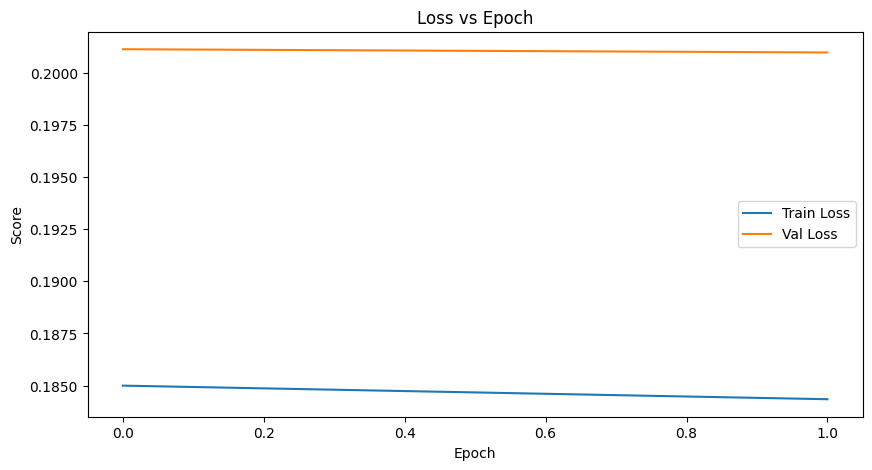

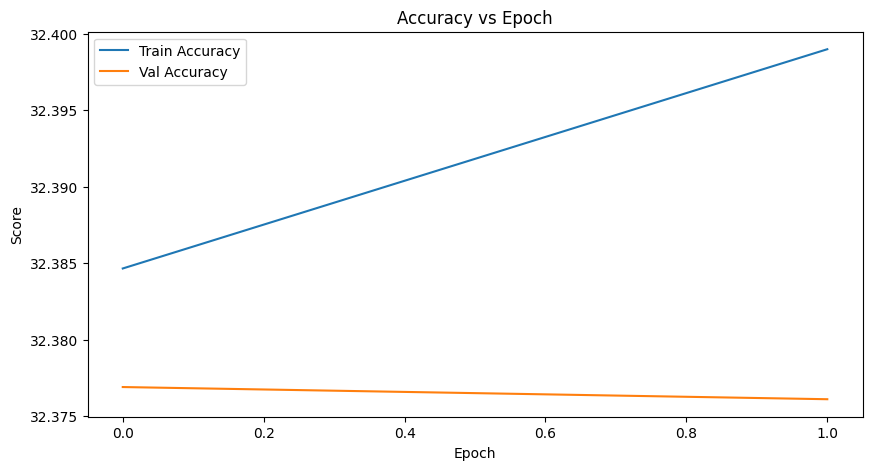

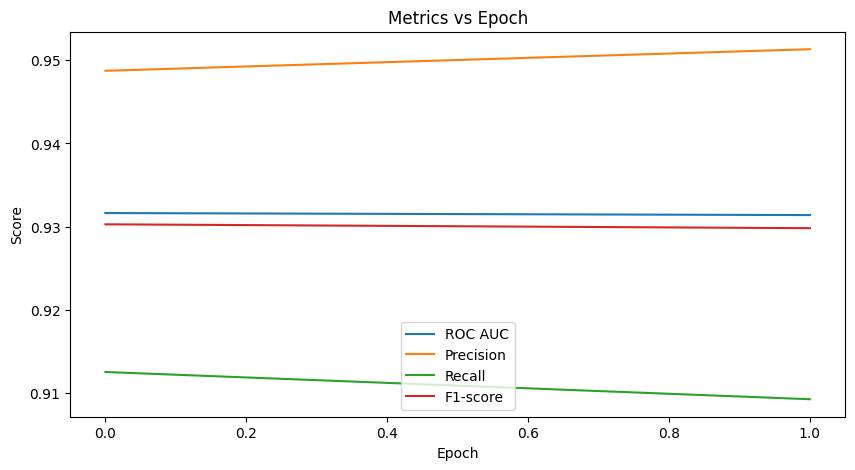

In [93]:
"""
Train the network
"""
model = train(model, criterion, optimizer, n_epoch=2)

In [57]:
def predict(model, input_data):
    model.eval()
    with torch.no_grad():
        logits = model(input_data.to(device))
        y_pred = (torch.sigmoid(logits) > 0.5).float().cpu()
    return y_pred.numpy()

In [105]:
"""
Real accuracy calculation
"""
some_preds = [predict(model, X_test[i].unsqueeze(0).unsqueeze(0)) for i in range(1000)]
some_reals = y_test[0:1000]

TF = 0 

for i in range(1000):
    if int(some_preds[i]) != some_reals[i]:
      TF += 1


print(f"The real accuracy is: {1-TF/1000}")

The real accuracy is: 0.927


In [96]:
def print_test_metrics(model, test_dataloader, criterion):
    accuracy, loss, roc_auc, precision, recall, f1 = evaluate(model, test_dataloader, criterion)
    
    print("Test Metrics:")
    print("Accuracy: {:.4f}".format(accuracy))
    print("Loss: {:.4f}".format(loss))
    print("ROC AUC: {:.4f}".format(roc_auc))
    print("Precision: {:.4f}".format(precision))
    print("Recall: {:.4f}".format(recall))
    print("F1-score: {:.4f}".format(f1))

In [97]:
print_test_metrics(model, test_dataloader, criterion)

Test Metrics:
Accuracy: 32.3761
Loss: 0.2010
ROC AUC: 0.9314
Precision: 0.9513
Recall: 0.9092
F1-score: 0.9298
